In [1]:
import regex as re
import torch
import torch.nn as nn
import pandas as pd
from normalizer import normalize
from transformers.modeling_outputs import TokenClassifierOutput, SequenceClassifierOutput
from transformers import AutoModelForSequenceClassification, AutoModel, AutoConfig

In [2]:
# Load Data
train = pd.read_csv('data/train.csv')
dev = pd.read_csv('data/dev.csv')
test = pd.read_csv('data/test.csv')

#preprocessing
def process_hashtags(text):
    # Remove initial hashtags
    text = re.sub(r'^#(\w+)', '', text).strip()

    # Extract keywords from hashtags, replace underscores with space
    def replace_hashtag(match):
        return match.group(1).replace('_', ' ')
    
    text = re.sub(r'#(\w+)', replace_hashtag, text)

    return text


#replace links with [URL]
train['text'] = train['text'].apply(lambda x: re.sub(r'http\S+', '[URL]', x))
dev['text'] = dev['text'].apply(lambda x: re.sub(r'http\S+', '[URL]', x))
test['text'] = test['text'].apply(lambda x: re.sub(r'http\S+', '[URL]', x))

# remove hashtag
train['text'] = train['text'].apply(process_hashtags)
dev['text'] = dev['text'].apply(process_hashtags)
test['text'] = test['text'].apply(process_hashtags)


In [3]:
# Map labels

id2label = {
    0 : 'Non-Violence',
    1 : 'Passive Violence',
    2 : 'Direct Violence'
}

label2id = {
    'Non-Violence': 0,
    'Passive Violence': 1,
    'Direct Violence': 2
}

# train['label'] = train['label_name'].map(label2id)
# validation['label'] = validation['label_name'].map(label2id)
#test['label'] = test['label_name'].map(label2id)
train.label.value_counts()

0    1389
1     922
2     389
Name: label, dtype: int64

<Axes: >

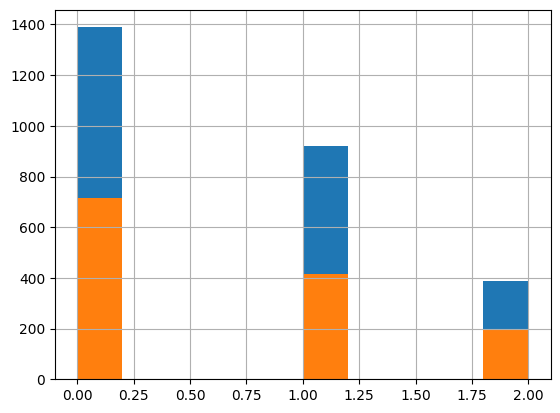

In [4]:
# train = train.drop(columns=['id', 'label_name'], axis=1)
# validation = validation.drop(['id', 'label_name'], axis=1)

#test = test.drop(['id'], axis=1)
train.label.hist()
dev.label.hist()

## Normalization

In [5]:
from bnunicodenormalizer import Normalizer
bnorm = Normalizer()

def normalize_sentence(sentence):
    words = sentence.split()
    normalized_words = []

    for word in words:
        normalized_word = bnorm(word)['normalized']
        if normalized_word is not None:
            normalized_words.append(normalized_word)
        else:
            normalized_words.append(word)  # Use the original word if normalization fails
    normalized_sentence = normalize(' '.join(normalized_words))
    return normalized_sentence

train['text'] = pd.DataFrame(train['text'].map(lambda x: normalize_sentence(x)))
dev['text'] = pd.DataFrame(dev['text'].map(lambda x: normalize_sentence(x)))
test['text'] = pd.DataFrame(test['text'].map(lambda x: normalize_sentence(x)))

#save test
test.to_csv('./data_gen/test.csv', index=False)

### Paraphrased Data (Lowest Class only)

In [6]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the models and tokenizers
MODELS = {
    "csebuetnlp/banglat5_banglaparaphrase": {
        "model": AutoModelForSeq2SeqLM.from_pretrained("csebuetnlp/banglat5_banglaparaphrase"),
        "tokenizer": AutoTokenizer.from_pretrained("csebuetnlp/banglat5_banglaparaphrase", use_fast=False)
    },
    "fuadalhasib/semantically-aware-banglat5-for-paraphrase": {
        "model": AutoModelForSeq2SeqLM.from_pretrained("fuadalhasib/semantically-aware-banglat5-for-paraphrase"),
        "tokenizer": AutoTokenizer.from_pretrained("fuadalhasib/semantically-aware-banglat5-for-paraphrase", use_fast=False)
    }
}

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
for _, model_data in MODELS.items():
    model_data["model"] = model_data["model"].to(device)

BATCH_SIZE = 64  # You can adjust this based on your GPU's memory.

def paraphrase_batch(texts, model, tokenizer):
    input_ids = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").input_ids.to(device)
    generated_tokens = model.generate(input_ids)
    return tokenizer.batch_decode(generated_tokens)

def paraphrase_class(data, label, model_name):
    model = MODELS[model_name]["model"]
    tokenizer = MODELS[model_name]["tokenizer"]
    
    class_texts = data[data['label'] == label]['text'].tolist()
    augmented_texts = []
    for i in range(0, len(class_texts), BATCH_SIZE):
        batch_texts = class_texts[i:i+BATCH_SIZE]
        augmented_texts.extend(paraphrase_batch(batch_texts, model, tokenizer))
    return pd.DataFrame({'text': augmented_texts, 'label': [label for _ in augmented_texts]})

# Choose which models to use for paraphrasing
selected_models = ["csebuetnlp/banglat5_banglaparaphrase"]  # Modify this list to choose the models
# "csebuetnlp/banglat5_banglaparaphrase" "fuadalhasib/semantically-aware-banglat5-for-paraphrase"

# Choose which classes to paraphrase
classes_to_paraphrase = [0, 1, 2]  # Modify this list to choose the classes
augmented_dataframes = []

for model_name in selected_models:
    for label in classes_to_paraphrase:
        augmented_dataframes.append(paraphrase_class(train, label, model_name))


# Concatenate the original train data and the augmented data
augmented_data = pd.concat(augmented_dataframes, axis=0).reset_index(drop=True)
paraphrased_train = pd.concat([train, augmented_data], ignore_index=True)


You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
/home/rohan/miniconda3/envs/textclassification/lib/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/rohan/miniconda3/envs/textclassification/lib/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `ma

In [7]:
augmented_data.label.value_counts()

0    1389
1     922
2     389
Name: label, dtype: int64

In [10]:
paraphrased_train.label.value_counts()

0    2778
1    1844
2     778
Name: label, dtype: int64

In [11]:
paraphrased_train.to_csv('./data_gen/train_paraphrased.csv', index=False)

### Back Translation based Data Augmentation

In [9]:
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the models and tokenizers and move them to GPU
tokenizer_bn_en = T5Tokenizer.from_pretrained("csebuetnlp/banglat5_nmt_bn_en")
model_bn_en = T5ForConditionalGeneration.from_pretrained("csebuetnlp/banglat5_nmt_bn_en").to(device)

tokenizer_en_bn = T5Tokenizer.from_pretrained("csebuetnlp/banglat5_nmt_en_bn")
model_en_bn = T5ForConditionalGeneration.from_pretrained("csebuetnlp/banglat5_nmt_en_bn").to(device)

def back_translate_batch(sentences: list) -> list:
    inputs = tokenizer_bn_en(sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    outputs = model_bn_en.generate(**inputs, max_length=256, num_return_sequences=1, temperature=0.6)
    translated_sentences = [tokenizer_bn_en.decode(output, skip_special_tokens=True).replace('<pad>', '').strip() for output in outputs]

    inputs = tokenizer_en_bn(translated_sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    outputs = model_en_bn.generate(**inputs, max_length=256, num_return_sequences=1, temperature=0.6)
    back_translated_sentences = [tokenizer_en_bn.decode(output, skip_special_tokens=True).replace('<pad>', '').strip() for output in outputs]

    return back_translated_sentences

def back_translate_class(data, label, BATCH_SIZE=32):
    filtered_train = data[data['label'] == label].reset_index(drop=True)
    backtranslated_texts = []
    original_labels = []  # Store the original labels of the sentences being back-translated
    
    for i in range(0, len(filtered_train), BATCH_SIZE):
        batch = filtered_train['text'].iloc[i:i+BATCH_SIZE].tolist()
        backtranslated_texts.extend(back_translate_batch(batch))
        # Append the labels from the original datapoints it was backtranslated from
        original_labels.extend(filtered_train['label'].iloc[i:i+BATCH_SIZE].tolist())
    
    # Create a dataframe with backtranslated texts and their corresponding original labels
    return pd.DataFrame({
        'text': backtranslated_texts,
        'label': original_labels
    })

# Choose which classes to back-translate
classes_to_backtranslate = [2]
synthetic_dataframes = []

for label in classes_to_backtranslate:
    synthetic_dataframes.append(back_translate_class(train, label))

# Concatenate the original train data and the synthetic data
synthetic_data = pd.concat(synthetic_dataframes, axis=0).reset_index(drop=True)
backtranslated_train = pd.concat([train, synthetic_data], axis=0).reset_index(drop=True)

In [10]:
backtranslated_train.tail(20) # may need to change max_length=200

,text,label
5380,"বাজার বন্ধ, তারা খারাপ আচরণ করে,",2
5381,পুলিশের সেই স্থানে যাওয়া উচিত নয় যেখানে এই ধ...,2
5382,আওয়ামী লীগকে ভেঙে দিতে হবে শেখ হাসিনার চোর সর...,2
5383,আমাদের দেশের বেশিরভাগ মেয়ে আধুনিক হিজাব পরে ন...,2
5384,ভারত বয়কট.,2
5385,সরকারি স্কুল-কলেজে পড়ার জন্য স্কুলের নির্দিষ্...,2
5386,"সব মুসলিম দেশ থেকে হিন্দুদের বয়কট করুন, হিন্দ...",2
5387,"এখন আমরা চার দেব না, এখন আমরা মসজিদ আক্রমণ করত...",2
5388,যুদ্ধের জন্য প্রস্তুত হতে সকল মুসলমানদের আহ্বা...,2
5389,"যারা ইসলামকে আঘাত করছে, আল্লাহ কাফেরদের উপর আপ...",2


## Save Data

In [11]:
# from datasets import load_dataset

# Split Data
random_seed = 42
backtranslated_train = backtranslated_train.sample(frac=1, random_state=random_seed)
#valid_df = train.drop(train_df.index)
# valid_df = validation
# test_df = test
#assert len(train) == len(train_df) + len(valid_df), "Dataset sizes don't add up" # check for proper split

# # Create New Data Files
# valid_df.to_csv('./data_gen/validation_data.csv', index=False)
backtranslated_train.to_csv('./data_gen/backtranslated_train.csv', index=False)
# test_df.to_csv('./data_gen/test_data.csv', index=False)
# #validation.to_csv('./data/test_data.csv', index=False)

# # Load Data (train + val)
# training_data = load_dataset("csv", data_files={'train': ['./data_gen/train_data.csv'],'validation': ['./data_gen/validation_data.csv']})

In [12]:
import pandas as pd
train = pd.read_csv('./data_gen/backtranslated_train.csv')


<Axes: >

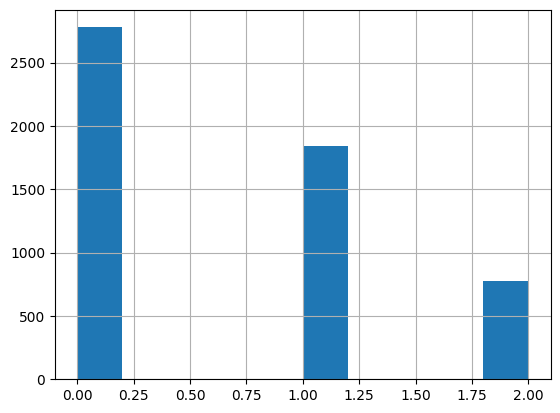

In [14]:
train.label.hist()